In [2]:
import scipy
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import scipy.sparse as sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from scipy.sparse import linalg as linalg
from scipy.sparse import lil_matrix as lil_matrix
import scipy.signal as signal
from google.colab import files

In [ ]:
dummy_mask = np.zeros((8, 8), dtype=bool)
dummy_mask[2:6, 2:6] = 1
dummy_target_img = np.arange(64).reshape(8, 8)
dummy_src_img = np.load('dummy_src_img.npy') # generated by np.random.randint(0, 256, size=(8, 8))
indexes = getIndexes(dummy_mask, dummy_mask.shape[0], dummy_mask.shape[1])
# compare with index.npy
#print(np.load('index.npy'))
#print(np.load('A.npy'))
#print(np.load('b.npy'))
A = getCoefficientMatrix(indexes, dummy_mask)
# compare with A.npy
b = getSolutionVect(indexes, dummy_src_img, dummy_target_img, 0, 0)
# compare with b.npy

mask.shape (8, 8)
[-704  355 -123  313  -49 -148  -70  -82  -85   95  121  206  562 -245
 -132 -165]


In [3]:
def getSur(index):
   
  i, j = index  # too many values to unpack, expected 2
   
  return [(i+1,j),(i-1,j),(i,j+1),(i,j-1)] 

In [4]:
def maskIndices(mask):
  nonzero = np.nonzero(mask)
  nz0 = np.array(nonzero[0])
  nz1 = np.array(nonzero[1])
    
  maskInxs = np.dstack((nz0, nz1))
  maskInxs = maskInxs.reshape((-1,2))
 
  return  maskInxs    

In [5]:
uploaded = files.upload()

Saving A.npy to A.npy
Saving b.npy to b.npy
Saving bean.jpg to bean.jpg
Saving dummy_src_img.npy to dummy_src_img.npy
Saving index.npy to index.npy
Saving mask_2.bmp to mask_2.bmp
Saving mask_3.bmp to mask_3.bmp
Saving mask_bean.bmp to mask_bean.bmp
Saving source_2.jpg to source_2.jpg
Saving source_3.jpg to source_3.jpg
Saving target_2.jpg to target_2.jpg
Saving target_3.jpg to target_3.jpg


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
def getIndexes(mask, targetH, targetW, offsetX=0, offsetY=0):
    """ Creates indexes in the target image, each replacement pixel in the
    target image would get index starting from 1, other pixels get 0 in the indexes.
   
    Args:
    mask: SrcH * SrcW, logical mask of source image
    targetH, targetW: int, height and width of target image
    offsetX, offsetY: int, offset of replacement pixel area from source to target

    Return:
    indexes: targetH * targetW, indexes of target image
    """
    mask[mask >0] = 1
    mask[mask != 1] = 0
   
    
    diffW = targetW - mask.shape[1]
    diffH = targetH - mask.shape[0]
  
    xMask, yMask = np.meshgrid(np.arange(mask.shape[1]), np.arange(mask.shape[0]))
    
    
    target_x, target_y = xMask[mask > 0], yMask[mask > 0]  
  
    
    indexes = np.zeros_like(mask)
    
    
    N = len(target_y)
  
       
    indexes[target_y, target_x] = np.arange(1, N+1) 
  
    mask0 = diffH - offsetY
    mask1 = diffW - offsetX
   
    indexesNew = np.pad(indexes, ((diffH-mask0, mask0), (diffW-mask1, mask1)), 'constant')
   
     
    return indexesNew
    
    

In [7]:
def getCoefficientMatrix(indexes, mask):
  """
  constructs the coefficient matrix(A in Ax=b)
  
  Args: 
  indexes: targetH * targetW, indexes of target image starting from 1, 0 if not in target area 
  
  returns:
  coeffA: N * N(N is max index), a matrix corresponds to laplacian kernel, 4 on the diagonal and -1 for each neighbor
  """

  coeffA = []
  
  coeffDim = 0
  for i in range(len(indexes)):
      for j in range(len(indexes[i])):
          if(indexes[i][j]>0):
              coeffDim += 1
                            
  
  coeffA = csr_matrix((coeffDim, coeffDim), dtype=np.int8).toarray()
   
  
  n = len(mask)
  maskNdx = maskIndices(mask)
  
  
  maskNdxList = maskNdx.tolist()
  #print(maskNdxList)
   
  for i in range(len(maskNdx)):           
        coeffA[i,i] = 4    
        for x in getSur(maskNdxList[i]):    
                x = list(x)
               
                if(x not in maskNdxList):    
                    continue
           
                j = maskNdxList.index(x)
                coeffA[i][j] = -1
  #print(coeffA)                
  return coeffA

In [8]:
def getSolutionVect(indexes, source, target, offsetX, offsetY):
    """
    constructs the target solution vector(b in Ax=b) 
    
    Args:
    indexes:  targetH * targetW, indexes of replacement area
    source, target: source and target image
    offsetX, offsetY: offset of source image origin in the target image

    Returns:
    solution vector b (for single channel)
    """
   

     
    lap = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])

    srcLap = signal.convolve(source, lap, 'same')
   
    
   
    diffH = target.shape[0] - source.shape[0]    
    diffW = target.shape[1] - source.shape[1]
    
    mask0 = diffH - offsetY
    mask1 = diffW - offsetX
   
    srcLapNew = np.pad(srcLap, ((diffH-mask0, mask0), (diffW-mask1, mask1)), 'constant')
     
    Y, X = np.nonzero(indexes)
   
    Y_src = Y
    X_src = X
  
    lapFinal = srcLapNew[Y_src, X_src]


# ^^^^^^^^^^^^^^^^^^^^^^ end laplacian part of b ^^^^^^^^^^^^^^^    

# vvvvvvvvvvvvvvvvvvvvvvv pixel part of b vvvvvvvvvvvvvvvvvvvvvvv    

    N = np.count_nonzero(indexes)
    
    leftNdx = np.zeros(N, dtype=np.int32)
   
    leftVal = np.zeros(N, dtype=np.float32)
   
    valid = X - 1 >= 0
    
    
    leftNdx = np.array(leftNdx)
   
    for i in range(len(valid)):
        q = valid[i]
        y = Y[q].flatten()
        #print('y: ', y)        
        x = (X-1)[q].flatten()
        #print('x: ', x)
        leftNdx[i] = indexes[y[i]][x[i]]                                                   
   
    good = np.logical_and(valid, leftNdx == 0)
    
    leftVal[good] = target[Y[good], (X - 1)[good]]
   
    
    rightNdx = np.zeros(N, dtype=np.int32)
    rightVal = np.zeros(N, dtype=np.float32) 
    
    
    valid = X + 1 >= 0
   
    for i in range(len(valid)):
        q = valid[i]
        y = Y[q].flatten()
      
        x = (X+1)[q].flatten()
    
        rightNdx[i] = indexes[y[i]][x[i]]
   
    good = np.logical_and(valid, rightNdx == 0)
    
    rightVal[good] = target[Y[good], (X + 1)[good]]

    upNdx = np.zeros(N, dtype=np.int32)
    upVal = np.zeros(N, dtype=np.float32) 
    valid = Y - 1 >= 0
  
    
    for i in range(len(valid)):
        q = valid[i]
        y = (Y-1)[q].flatten()
        #print('y: ', y)        
        x = X[q].flatten()
        #print('x: ', x)
        upNdx[i] = indexes[y[i]][x[i]]
   
    good = np.logical_and(valid, upNdx == 0)
  
    upVal[good] = target[(Y-1)[good], (X)[good]]
  
    downNdx = np.zeros(N, dtype=np.int32)
    downVal = np.zeros(N, dtype=np.float32) 
    valid = Y + 1 >= 0
   
    for i in range(len(valid)):
        q = valid[i]
        y = (Y+1)[q].flatten()
       
        x = X[q].flatten()
       
        downNdx[i] = indexes[y[i]][x[i]]
 
    good = np.logical_and(valid, downNdx == 0)
   
    downVal[good] = target[(Y+1)[good], (X)[good]]
 

    b = np.zeros(N)
    for i in range(N):
        b[i] = lapFinal[i] + leftVal[i] + rightVal[i] + upVal[i] + downVal[i]
  
  
    return b

In [9]:
def solveEqu(A, b):
  """
  solve the equation Ax = b to get replacement pixels x in the replacement area
  Note: A is a sparse matrix, so we need to use coresponding function to solve it

  Args:
   A: Laplacian coefficient matrix
   b: target solution vector
  
  Returns:
   x: solution of Ax = b
  """

  coeffDim = len(A)
  
  A = csr_matrix(A)
  
  b = b.reshape((-1))
  
  f = scipy.sparse.linalg.spsolve(A, b) 
  
  return f
  

In [11]:
def reconstructImg(indexes, red, green, blue, targetImg):
    """
    reconstruct the target image with new red, green, blue channel values in 
    the indexes area

    red, green, blue: 1 x N, three chanels for replacement pixels
    """
 # 1. get nonzero component in indexes
    
    ndxNonZeroTup = np.nonzero(indexes)
    np.set_printoptions(threshold=20)    
    nz0 = np.array(ndxNonZeroTup[0])
    nz1 = np.array(ndxNonZeroTup[1])
    ndxNonZero = np.dstack((nz0, nz1))
    ndxNonZero = ndxNonZero.reshape((-1,2))
  

    # 2. stack three channels together with numpy dstack
    resStack = np.dstack((red, green, blue))
  
    resStack = resStack.reshape((-1, 3))
  
    
    targetCopy = np.ndarray.copy(targetImg)
   
    
        
    for i in range(ndxNonZero.shape[0]):             
        targetCopy[ndxNonZero[i][0],ndxNonZero[i][1], 0] = red[i]  
        targetCopy[ndxNonZero[i][0],ndxNonZero[i][1], 1] = green[i]
        targetCopy[ndxNonZero[i][0],ndxNonZero[i][1], 2] = blue[i]        
    
    return targetCopy



In [12]:
"""
Function (do not modify)
"""
def seamlessCloningPoisson(sourceImg, targetImg, mask, offsetX, offsetY):
    """
    Wrapper function to put all steps together
    Args:
    - sourceImg, targetImg: source and targe image
    - mask: masked area in the source image
    - offsetX, offsetY: offset of the mask in the target image
    Returns:
    - ResultImg: result image
    """
    # step 1: index replacement pixels
    indexes = getIndexes(mask, targetImg.shape[0], targetImg.shape[1], offsetX,
                         offsetY)
    # step 2: compute the Laplacian matrix A
    A = getCoefficientMatrix(indexes, mask)

    # step 3: for each color channel, compute the solution vector b
    red, green, blue = [
        getSolutionVect(indexes, sourceImg[:, :, i], targetImg[:, :, i],
                        offsetX, offsetY).T for i in range(3)
    ]

    # step 4: solve for the equation Ax = b to get the new pixels in the replacement area
    new_red, new_green, new_blue = [
        solveEqu(A, channel)
        for channel in [red, green, blue]
    ]

    # step 5: reconstruct the image with new color channel
    resultImg = reconstructImg(indexes, new_red, new_green, new_blue,
                               targetImg)
    return resultImg

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


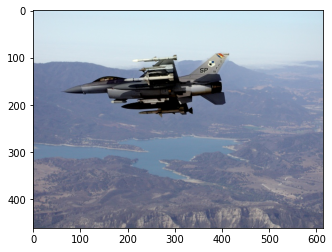

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
"""
Script (do not modify)
"""
src_path = 'source_3.jpg'
src = np.array(Image.open(src_path).convert('RGB'), 'f') / 255
target_path  ='target_3.jpg'
target = np.array(Image.open(target_path).convert('RGB'), 'f') / 255
offsetX = 40
offsetY = 20
mask_path = 'mask_3.bmp'
mask = np.array(Image.open(mask_path)) > 0
result = seamlessCloningPoisson(src, target, mask, offsetX, offsetY)
plt.imshow(result)
plt.show()
cloned = Image.fromarray((np.clip(result, 0, 1) * 255).astype(np.uint8))
cloned.save('cloned.png')
files.download('cloned.png')

In [20]:
def getSolutionVectMixing(indexes, source, target, offsetX, offsetY):
    """
    constructs the target solution vector(b in Ax=b) 
    
    Args:
    indexes:  targetH * targetW, indexes of replacement area
    source, target: source and target image
    offsetX, offsetY: offset of source image origin in the target image

    Returns:
    solution vector b (for single channel)
    almost the same as getSolutionVect, need to change the Laplacian part of b
  
    """

   
    lap = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    
  
    srcLap = signal.convolve(source, lap, 'same')
   
    diffH = target.shape[0] - source.shape[0]    
    diffW = target.shape[1] - source.shape[1]
            
    mask0 = diffH - offsetY
    mask1 = diffW - offsetX
        
    srcLapNew = np.pad(srcLap, ((diffH-mask0, mask0), (diffW-mask1, mask1)), 'constant')
    
    Y, X = np.nonzero(indexes)
   
    Y_src = Y 
    X_src = X
   
    lapSrcFinal = srcLapNew[Y_src, X_src]   
   
    trgLap = signal.convolve(target, lap, 'same')
    
    lapTrgFinal = trgLap[Y_src, X_src]
    
     
    
    
    
# ^^^^^^^^^^^^^^^^^^^^^^ end laplacian part of b ^^^^^^^^^^^^^^^    

# vvvvvvvvvvvvvvvvvvvvvvv pixel part of b vvvvvvvvvvvvvvvvvvvvvvv    

    N = np.count_nonzero(indexes)
  
    leftNdx = np.zeros(N, dtype=np.int32)
   
    leftVal = np.zeros(N, dtype=np.float32)
  
    valid = X - 1 >= 0
   
  
    leftNdx = np.array(leftNdx)
   
    for i in range(len(valid)):
        q = valid[i]
        y = Y[q].flatten()
        #print('y: ', y)        
        x = (X-1)[q].flatten()
        #print('x: ', x)
        leftNdx[i] = indexes[y[i]][x[i]]                                         
   
    
    good = np.logical_and(valid, leftNdx == 0)
    
    
    leftVal[good] = target[Y[good], (X - 1)[good]]
    
    rightNdx = np.zeros(N, dtype=np.int32)
    rightVal = np.zeros(N, dtype=np.float32) 
    
   
    valid = X + 1 >= 0
   
   
    for i in range(len(valid)):
        q = valid[i]
        y = Y[q].flatten()
            
        x = (X+1)[q].flatten()
       
        rightNdx[i] = indexes[y[i]][x[i]]
    
    good = np.logical_and(valid, rightNdx == 0)
   
    rightVal[good] = target[Y[good], (X + 1)[good]]
    

    upNdx = np.zeros(N, dtype=np.int32)
    upVal = np.zeros(N, dtype=np.float32) 
    valid = Y - 1 >= 0
   
    for i in range(len(valid)):
        q = valid[i]
        y = (Y-1)[q].flatten()
          
        x = (X)[q].flatten()
      
        upNdx[i] = indexes[y[i]][x[i]]
   
    good = np.logical_and(valid, upNdx == 0)
     
    upVal[good] = target[(Y-1)[good], (X)[good]]
    
    
    
    downNdx = np.zeros(N, dtype=np.int32)
    downVal = np.zeros(N, dtype=np.float32) 
    valid = Y + 1 >= 0
    
    for i in range(len(valid)):
        q = valid[i]
        y = (Y+1)[q].flatten()
     
        x = (X)[q].flatten()
      
        downNdx[i] = indexes[y[i]][x[i]]
    
    good = np.logical_and(valid, downNdx == 0)
    
    downVal[good] = target[(Y+1)[good], (X)[good]]
    

    bSrc = np.zeros(N)
    bTrg = np.zeros(N)
    b    = np.zeros(N)
    
    for i in range(N):
        bSrc[i] = lapSrcFinal[i] + leftVal[i] + rightVal[i] + upVal[i] + downVal[i]
        bTrg[i] = lapTrgFinal[i] + leftVal[i] + rightVal[i] + upVal[i] + downVal[i]
        
        #"""
        if(abs(bSrc[i])>=abs(bTrg[i])):    
            b[i] = bSrc[i]
        else:
            b[i] = bTrg[i]
      
       
    return b
    

In [21]:
"""
Function (do not modify)
"""
def PoissonMixing(sourceImg, targetImg, mask, offsetX, offsetY):
    """
    Wrapper function to put all steps together
    Args:
    - sourceImg, targetImg: source and target image
    - mask: masked area in the source image
    - offsetX, offsetY: offset of the mask in the target image
    Returns:
    - ResultImg: result image
    """
    # step 1: index replacement pixels
    indexes = getIndexes(mask, targetImg.shape[0], targetImg.shape[1], offsetX,
                         offsetY)
    # step 2: compute the Laplacian matrix A
    A = getCoefficientMatrix(indexes, mask)

    # step 3: for each color channel, compute the solution vector b
    red, green, blue = [
        getSolutionVectMixing(indexes, sourceImg[:, :, i], targetImg[:, :, i],
                        offsetX, offsetY).T for i in range(3)
    ]

    # step 4: solve for the equation Ax = b to get the new pixels in the replacement area
    new_red, new_green, new_blue = [
        solveEqu(A, channel)
        for channel in [red, green, blue]
    ]

    # step 5: reconstruct the image with new color channel
    resultImg = reconstructImg(indexes, new_red, new_green, new_blue,
                               targetImg)
    return resultImg

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


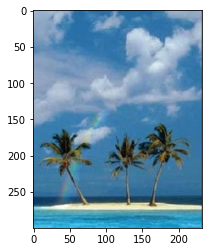

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
"""
Script (do not modify)
"""
src_path = 'source_2.jpg'
src = Image.open(src_path).convert('RGB')

src = np.array(src, 'f') / 255
target_path  ='target_2.jpg'
target = Image.open(target_path).convert('RGB')
target = np.array(target, 'f') / 255
offsetX = 10
offsetY = 130
mask_path = 'mask_2.bmp'
mask = Image.open(mask_path)
mask =np.array(mask) > 0
result = PoissonMixing(src, target, mask, offsetX, offsetY)
plt.imshow(result)
plt.show()
mixed = Image.fromarray((np.clip(result, 0, 1) * 255).astype(np.uint8))
mixed.save('mixed.png')
files.download('mixed.png')

In [25]:
def getSolutionVectTexture(indexes, target, mask, edges):
    """
    constructs the target solution vector(b in Ax=b) 
    
    Args:
    indexes:  targetH * targetW, indexes of replacement area
    source, target: source and target image
    offsetX, offsetY: offset of source image origin in the target image

    Returns:
    solution vector b (for single channel)
    """
    Y, X = np.nonzero(indexes)
    
    N = np.count_nonzero(indexes)
    
    leftNdx = np.zeros(N, dtype=np.int32)
   
    leftVal = np.zeros(N, dtype=np.float32)
   
    lapLeft = np.array([[ -1, 1]])
    lapLeft = signal.convolve(target, lapLeft, 'same')
   
    lapLeft = lapLeft[Y, X] 
    
    valid = (X - 1 >= 0) 
  
    leftNdx = np.array(leftNdx)
    for i in range(len(valid)):
        
            q = valid[i]
            y = Y[q].flatten()
               
            x = (X-1)[q].flatten()
           
            if(edges[y[i]][x[i]]):
                leftNdx[i] = indexes[y[i]][x[i]]                                                   
    
    good = np.logical_and(valid, leftNdx == 0)
   
    
    leftVal[good] = target[Y[good], (X - 1)[good]]
    
    rightNdx = np.zeros(N, dtype=np.int32)
    rightVal = np.zeros(N, dtype=np.float32)
    
    lapRight = np.array([[ 1, -1]])
    lapRight = signal.convolve(target, lapRight, 'same')
    
    lapRight = lapRight[Y, X]  

    valid = (X + 1) >= 0
    
    for i in range(len(valid)):
            q = valid[i]
            y = Y[q].flatten()
                  
            x = (X+1)[q].flatten()
            
            if(edges[y[i]][x[i]]):
                rightNdx[i] = indexes[y[i]][x[i]]
    
    good = np.logical_and(valid, rightNdx == 0)
    
    rightVal[good] = target[Y[good], (X + 1)[good]]

    upNdx = np.zeros(N, dtype=np.int32)
    upVal = np.zeros(N, dtype=np.float32) 
    
    lapUp = np.array([[ -1], [1]]) 
    lapUp = signal.convolve(target, lapUp, 'same')
   
    lapUp = lapUp[Y, X] 

    valid = (Y - 1) >= 0
    
    for i in range(len(valid)):
            q = valid[i]
            y = (Y-1)[q].flatten()
                
            x = (X)[q].flatten()
           
            if(edges[y[i]][x[i]]):
                upNdx[i] = indexes[y[i]][x[i]]
    
    good = np.logical_and(valid, upNdx == 0)
   
    upVal[good] = target[(Y-1)[good], (X)[good]]
    
    downNdx = np.zeros(N, dtype=np.int32)
    downVal = np.zeros(N, dtype=np.float32)
    
    lapDown = np.array([[ -1], [1]]) 
    lapDown = signal.convolve(target, lapDown, 'same')
   
    lapDown = lapDown[Y, X] 
    
    valid = (Y + 1) >= 0
  
    for i in range(len(valid)):
            q = valid[i]
            y = (Y+1)[q].flatten()
                
            x = X[q].flatten()
           
            if(edges[y[i]][x[i]]):
                downNdx[i] = indexes[y[i]][x[i]]
   
    good = np.logical_and(valid, downNdx == 0)
   
    downVal[good] = target[(Y+1)[good], (X)[good]]
    
    b = np.zeros(N)
    
    for i in range(N):
        b[i] = leftVal[i] + rightVal[i] + upVal[i] + downVal[i]
  
       
    return b

In [28]:
"""
Function (do not modify)
"""
def PoissonTextureFlattening(targetImg, mask, edges):
    """
    Wrapper function to put all steps together
    Args:
    - targetImg: target image
    - mask: masked area in the source image
    - offsetX, offsetY: offset of the mask in the target image
    Returns:
    - ResultImg: result image
    """
    # step 1: index replacement pixels
    indexes = getIndexes(mask, targetImg.shape[0], targetImg.shape[1])
    # step 2: compute the Laplacian matrix A
    A = getCoefficientMatrix(indexes, mask)

    # step 3: for each color channel, compute the solution vector b
    red, green, blue = [
        getSolutionVectTexture(indexes, targetImg[:, :, i], mask, edges).T for i in range(3)
    ]

    # step 4: solve for the equation Ax = b to get the new pixels in the replacement area
    new_red, new_green, new_blue = [
        solveEqu(A, channel)
        for channel in [red, green, blue]
    ]

    # step 5: reconstruct the image with new color channel
    resultImg = reconstructImg(indexes, new_red, new_green, new_blue,
                               targetImg)
    return resultImg

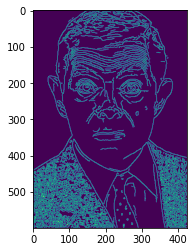

KeyboardInterrupt: ignored

In [29]:
"""
Script (do not modify)
"""
target_path  ='bean.jpg'
target = np.array(Image.open(target_path).convert('RGB'), 'f') / 255
from skimage.color import rgb2gray
from skimage import feature
edges = feature.canny(rgb2gray(target))
plt.imshow(edges)
plt.show()
mask_path = 'mask_bean.bmp'
mask = np.array(Image.open(mask_path)) > 0
result = PoissonTextureFlattening(target, mask, edges)
plt.imshow(result)
plt.show()
flatten = Image.fromarray((np.clip(result, 0, 1) * 255).astype(np.uint8))
flatten.save('flatten.png')
files.download('flatten.png')